# **Tests for the Networks**

In [1]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import text, inspect, MetaData

from tqdm import tqdm
import numpy as np
from pathlib import Path
import pandas as pd
from itertools import product
import datetime as dt

from dateutil.relativedelta import relativedelta
from scipy.stats import linregress

import nxviz as nv
import networkx as nx
from nxviz import layouts, plots, lines
from nxviz import nodes, edges, annotate, highlights
from nxviz.plots import despine, rescale, respine, aspect_equal

from nxviz.utils import edge_table, node_table
from nxviz import encodings as aes

import matplotlib
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Tahoma"]

basepath = Path.home().joinpath("Documents", "data")

/home/higorsmonteiro/anaconda3/envs/saude/lib/python3.11/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## **Definitions**

### **Database query**

In [2]:
# -- test
def query_metadata(engine):
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    table_dict = { table_name : inspector.get_columns(table_name) for table_name in tables }
    return table_dict


def perform_query(query_str, engine, batchsize=1000):

    schema_data = {
        'rows': [],
        'columns': [],
    }

    query_str = text(query_str)
    with engine.connect() as conn:
        qres = conn.execute(query_str)
        schema_data['columns'] = list(qres.keys())

        while True:
            rows = qres.fetchmany(batchsize)
            if not rows:
                break
            schema_data["rows"] += [ row for row in rows ]
    
    res_df = pd.DataFrame(schema_data['rows'], columns=schema_data['columns'])
    return res_df

### **Network definitions - SIH fluxes**

#### **Database query definitions**

In [3]:
def select_period_aih(engine, start_date, final_date, diag_level=0):
    '''
        Filter the AIH records for the period selected and considering the 
        diagnostic level of information required.

        'diag_level' refers to the number of chars to be considered in the 
        diagnostic ICD-10 of a hospital admission.
    '''
    if diag_level>4:
        diag_level = 4
    elif diag_level<0:
        diag_level = 0
    
    query = f'''
        SELECT 
            N_AIH, CNES, MUNIC_RES, MUNIC_MOV, VAL_TOT,
            SUBSTR(DIAG_PRINC,1,{diag_level}) as DIAG_CATEG 
        FROM aih_reduzida
        WHERE DT_INTER >= '{start_date.strftime("%Y-%m-%d")}' AND DT_INTER <= '{final_date.strftime("%Y-%m-%d")}'
    '''
    df = perform_query(query, engine)
    return df

def select_period_aih_services(engine, start_date, final_date):
    '''
        Filter the AIH records for the period selected and considering the 
        diagnostic level of information required.

        Here, the AIH records are selected together with all medical services performed
        for each hospital admission.
    '''
    query = f'''
        SELECT 
            a.*, b.SP_ATOPROF , b.SP_QTD_ATO
        FROM (
            SELECT 
                N_AIH, CNES, MUNIC_RES, MUNIC_MOV, ANO_CMPT, MES_CMPT
            FROM aih_reduzida
            WHERE DT_INTER >= '{start_date.strftime("%Y-%m-%d")}' AND DT_INTER <= '{final_date.strftime("%Y-%m-%d")}'
        ) a
        LEFT JOIN servicos_profissionais b
        WHERE a.N_AIH = b.SP_NAIH AND a.ANO_CMPT = b.SP_AA AND a.MES_CMPT = b.SP_MM
    '''
    df = perform_query(query, engine)
    df = df.drop_duplicates(subset=["N_AIH", "SP_ATOPROF"], keep='first')
    return df

def select_cnes_equip_data(engine, reference_date):
    '''
    
    '''
    query = f'''
        SELECT
            a.*, b.CODUFMUN, b.VINC_SUS, b.TPGESTAO,
            b.ESFERA_A, b.NATUREZA, b.TP_UNID
        FROM (
            SELECT
                *
            FROM equipamentos_mes
            WHERE COMPET = '{reference_date.strftime("%Y-%m-%d 00:00:00.000000")}'
        ) a
        LEFT JOIN cnes b
        WHERE a.CNES = b.CNES
    '''
    df = perform_query(query, engine)
    df["EQUIP_KEY"] = df["TIPEQUIP"]+'-'+df["CODEQUIP"]
    return df

#### **Edgelist definitions**

In [4]:
# -- City2City Networks (C2C)

def edgelist_c2c(engine, start_date, final_date, diag_level, mode='people'):
    '''
        Create the edgelist for the City2City networks.

        Given a period between 'start_date' and 'final_date', the function retrieves hospital admission
        data for this period and create the edgelist with pairs of cities and their corresponding weights.
        For this network, the weight can be regarded as vector $\vec{w}$ of m entries. Each entry corresponds 
        to a group of disease. The coarsing of the group depends on 'diag_level'. For instance, if 'diag_level'=1,
        then each weight $w_i$ corresponds to a group of diseases given by the first letter of the ICD-10 code.
        If 'mode'='people', then the value of a weight will correspond to the amount of flux of people carried
        in the current edge.
        If 'mode'='money', then the value of a weight will correspond to the amount of flux of money carried in
        the current edge.

        Args:
        -----
            engine:
                sqlalchemy.engine.base.Engine. SQLAlchemy engine responsible for the connection to the database
                of fluxes.
            start_date:
                datetime.datetime.
            final_date:
                datetime.datetime.
            diag_level:
                Integer. Coarsening level of the ICD-10 code associated to the hospital admission. For instance, 
                if 'diag_level'=1, any flux of admissions due to disease 'B34.2' (Covid-19) will be grouped into
                the disease group 'B'. If 'diag_level'=2, the example will be grouped as 'B3'. If 'diag_level'=0,
                then the weight vector will have only one entry corresponding to the total sum of fluxes with no
                discrimination of disease.
            mode:
                String.
                Options=['people', 'money']. See description.

        Returns:
        --------
            edgelist:
                pandas.DataFrame.
    '''
    df = select_period_aih(engine, start_date, final_date, diag_level=diag_level)
    if mode == 'people':
        edgelist = df.groupby(["MUNIC_RES", "MUNIC_MOV"])["DIAG_CATEG"].value_counts().reset_index()
        edgelist = pd.pivot_table(edgelist, index=["MUNIC_RES", "MUNIC_MOV"], columns="DIAG_CATEG", values="count").fillna(0)
    elif mode == 'money':
        edgelist = df.groupby(["MUNIC_RES", "MUNIC_MOV", "DIAG_CATEG"])["VAL_TOT"].sum().reset_index()
        edgelist = pd.pivot_table(edgelist, index=["MUNIC_RES", "MUNIC_MOV"], columns="DIAG_CATEG", values="VAL_TOT").fillna(0)
    edgelist["SOMA"] = edgelist.apply(sum, axis=1)
    return edgelist

def edgelist_services_c2c(engine, start_date, final_date):
    '''
        Create the edgelist for the City2City networks where the weight vector will divided into
        medical services performed for each hospital admission.

        The expression "city i has a set of directed edges towards city j" in this case refers to all medical services
        that were exported from i to j through the flux of people.
    '''
    df = select_period_aih_services(engine, start_date, final_date)
    edgelist = df.groupby(["MUNIC_RES", "MUNIC_MOV"])["SP_ATOPROF"].value_counts().reset_index()
    edgelist = pd.pivot_table(edgelist, index=["MUNIC_RES", "MUNIC_MOV"], columns="SP_ATOPROF", values="count").fillna(0)
    edgelist["SOMA"] = edgelist.apply(sum, axis=1)
    return edgelist

# -- City2Hospital Networks (C2H)

def edgelist_c2h(engine, start_date, final_date, diag_level, mode='people'):
    '''
        ...
    '''
    df = select_period_aih(engine, start_date, final_date, diag_level=diag_level)
    if mode == 'people':
        edgelist = df.groupby(["MUNIC_RES", "CNES"])["DIAG_CATEG"].value_counts().reset_index()
        edgelist = pd.pivot_table(edgelist, index=["MUNIC_RES", "CNES"], columns="DIAG_CATEG", values="count").fillna(0)
    elif mode == 'money':
        edgelist = df.groupby(["MUNIC_RES", "CNES", "DIAG_CATEG"])["VAL_TOT"].sum().reset_index()
        edgelist = pd.pivot_table(edgelist, index=["MUNIC_RES", "CNES"], columns="DIAG_CATEG", values="VAL_TOT").fillna(0)
    edgelist["SOMA"] = edgelist.apply(sum, axis=1)
    return edgelist

def edgelist_services_c2h(engine, start_date, final_date):
    '''
        ...
    '''
    df = select_period_aih_services(engine, start_date, final_date)
    edgelist = df.groupby(["MUNIC_RES", "CNES"])["SP_ATOPROF"].value_counts().reset_index()
    edgelist = pd.pivot_table(edgelist, index=["MUNIC_RES", "CNES"], columns="SP_ATOPROF", values="count").fillna(0)
    edgelist["SOMA"] = edgelist.apply(sum, axis=1)
    return edgelist

# -- Hospital2Diseases Networks (H2D)
def edgelist_h2d(engine, start_date, final_date):
    df = select_period_aih(engine, start_date, final_date, diag_level=3)
    edgelist = df.groupby(["CNES"])["DIAG_CATEG"].value_counts().reset_index().rename({"count": "TOTAL"}, axis=1)
    edgelist_ = df.groupby(["CNES", "DIAG_CATEG"])["VAL_TOT"].sum().reset_index().rename({"VAL_TOT": "VALOR_TOTAL"}, axis=1)
    edgelist = edgelist.merge(edgelist_, on=["CNES", "DIAG_CATEG"], how="inner")
    return edgelist

# -- Hospital2HealthServices (H2HS)
def edgelist_h2hs(engine, start_date, final_date):
    df = select_period_aih_services(engine, start_date, final_date)
    edgelist = df.groupby(["CNES"])["SP_ATOPROF"].value_counts().reset_index().rename({"count": "TOTAL"}, axis=1)
    return edgelist

# -- Health equipaments (maybe also include physicians) to Hospital/Municipality (E2H and E2M)
def edgelist_equip2_h_m(engine, reference_date, mode="hospital"):
    '''
        ...

        Args:
        -----
            reference_date:
                datetime.datetime. Date for extracting year and month of the data point to create the network.
            mode:
                String. Options = ['hospital', 'municip']
    '''
    cnes_df = select_cnes_equip_data(engine, reference_date)
    cnes_df["QT_EXIST"] = cnes_df["QT_EXIST"].astype(int)
    cnes_df["QT_USO"] = cnes_df["QT_USO"].astype(int)
    if mode=='hospital':
        edgelist = cnes_df.groupby(["EQUIP_KEY", "CNES"])[["QT_EXIST", "QT_USO"]].sum().reset_index().rename({"count": "TOTAL"}, axis=1)
    elif mode=="municip":
        edgelist = cnes_df.groupby(["EQUIP_KEY", "CODUFMUN"])[["QT_EXIST", "QT_USO"]].sum().reset_index().rename({"count": "TOTAL"}, axis=1)
    else:
        raise Exception("'hospital' or 'municip' are the only available options.")
    return edgelist

#### **Create networks**

In [5]:
def create_network(edgelist_df, net_type="c2c"):
    '''
    
    '''
    # -- default (c2c)
    if net_type=="c2c":
        source_nm, target_nm = "MUNIC_RES", "MUNIC_MOV" 
        graph = nx.DiGraph()
    elif net_type=="c2h":
        source_nm, target_nm = "MUNIC_RES", "CNES"
        graph = nx.DiGraph()
    elif net_type=="h2d":
        source_nm, target_nm = "CNES", "DIAG_CATEG"
        graph = nx.Graph() 
    elif net_type=="h2hs":
        source_nm, target_nm = "CNES", "SP_ATOPROF"
        graph = nx.Graph()
    elif net_type=="equip2hospital":
        source_nm, target_nm = "EQUIP_KEY", "CNES"
        graph = nx.Graph()
    elif net_type=="equip2mun":
        source_nm, target_nm = "EQUIP_KEY", "MUNIC_MOV"
        graph = nx.Graph()
    else:
        raise Exception("type not included.")  
        
    # Iterate through the dataframe and add edges with all edge attributes
    for idx, row in edgelist_df.iterrows():
        node_res = row[source_nm]
        node_mov = row[target_nm]
    
        # Get the edge attributes (all columns except the first two)
        edge_attributes = row.drop([source_nm, target_nm]).to_dict()
    
        # Add the edge with its attributes
        graph.add_edge(node_res, node_mov, **edge_attributes)
    return graph

## **Test Runnings - Networks**

In [16]:
basepath = Path.home().joinpath("Documents", "data")
sih_location = basepath.joinpath("opendatasus")
sih_name = "SIHSUS_NORDESTE_NO_SERVICE.db"

cnes_location = basepath.joinpath("opendatasus", "cnes")
cnes_name = "CNES_NORDESTE.db"

sih_engine_url = f"sqlite:///{sih_location.joinpath(sih_name)}"
sih_engine = create_engine(sih_engine_url)

cnes_engine_url = f"sqlite:///{cnes_location.joinpath(cnes_name)}"
cnes_engine = create_engine(cnes_engine_url)

### **Basic interaction with the database**

In [17]:
q = f'''
    SELECT * FROM aih_reduzida LIMIT 5
'''

df = perform_query(q, sih_engine)
df.head(4)

,N_AIH,UF_ZI,ANO_CMPT,MES_CMPT,ESPEC,IDENT,MUNIC_RES,NASC,SEXO,UTI_MES_TO,...,MORTE,NACIONAL,CAR_INT,GESTOR_COD,GESTOR_TP,CNES,CID_MORTE,COMPLEX,FINANC,FONTE
0,2308100006069,230000,2008,01,03,1,230540,1928-03-15 00:00:00.000000,3,0,...,0,010,02,None,0,2611309,None,02,06,CE0801
1,2308100006080,230000,2008,01,03,1,230540,1982-01-17 00:00:00.000000,1,0,...,0,010,02,None,0,2611309,None,02,06,CE0801
2,2308100006102,230000,2008,01,03,1,230540,1979-08-02 00:00:00.000000,3,0,...,0,010,02,None,0,2611309,None,02,06,CE0801
3,2308100006146,230000,2008,01,03,1,230540,1929-04-01 00:00:00.000000,3,0,...,0,010,02,None,0,2611309,None,02,06,CE0801


In [18]:
q = f'''
    SELECT * FROM servicos_profissionais LIMIT 5
'''

df = perform_query(q, sih_engine)
df.head(4)

,SP_NAIH,SP_GESTOR,SP_AA,SP_MM,SP_CNES,SP_PROCREA,SP_ATOPROF,SP_QTD_ATO,SP_PTSP,SP_VALATO,SP_M_HOSP,SP_M_PAC,SP_COMPLEX,SP_FINANC,SP_PF_CBO,SP_CIDPRI,SP_QT_PROC,SP_U_AIH,FONTE


In [19]:
q = f'''
    SELECT * FROM aih_rejeitada LIMIT 5
'''

df = perform_query(q, sih_engine)
df.head(4)

,N_AIH,UF_ZI,ANO_CMPT,MES_CMPT,MUNIC_RES,NASC,SEXO,UTI_MES_TO,MARCA_UTI,UTI_INT_TO,...,COD_IDADE,IDADE,MORTE,NACIONAL,CAR_INT,CNES,RACA_COR,ST_SITUAC,ST_BLOQ,ST_MOT_BLO
0,None,230000,2008,01,230570,1949-05-16 00:00:00.000000,1,0,00,0,...,4,58,0,010,01,2554771,03,1,0,00
1,None,230000,2008,01,230570,1953-03-01 00:00:00.000000,1,0,00,0,...,4,54,0,010,01,2554771,03,1,0,00
2,None,230000,2008,01,230570,1939-04-02 00:00:00.000000,3,0,00,0,...,4,68,0,010,01,2554771,03,1,0,00
3,None,230000,2008,01,230570,1982-03-13 00:00:00.000000,3,0,00,0,...,4,25,0,010,01,2554771,03,1,0,00


### **Test edgelist functions**

In [83]:
start_date, final_date = dt.datetime(2015, 1, 1), dt.datetime(2015, 12, 31)

In [19]:
aih_df = select_period_aih(sih_engine, start_date, final_date, diag_level=3)
aih_df.head(4)

,N_AIH,CNES,MUNIC_RES,MUNIC_MOV,VAL_TOT,DIAG_CATEG
0,2315105494757,6779522,230320,230730,384.80,E11
1,2315100001775,2785900,230440,230440,614.42,J18
2,2315100004020,2785900,230440,230440,211.13,J21
3,2315100010036,2785900,230440,230440,1016.16,J18


In [8]:
# -- c2c (diseases)
c2c_disease = edgelist_c2c(sih_engine, start_date, final_date, diag_level=3, mode="people")
print(c2c_disease.shape)
c2c_disease.head(4)

(2022, 1320)


,DIAG_CATEG,A00,A01,A02,A03,A04,A05,A06,A07,A08,A09,...,Z47,Z48,Z52,Z53,Z73,Z80,Z87,Z93,Z98,SOMA
MUNIC_RES,MUNIC_MOV,,,,,,,,,,,,,,,,,,,,,
110002,230440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
110012,230440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
110018,230440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
110020,230260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [78]:
# -- c2c (service)
c2c_service = edgelist_services_c2c(sih_engine, start_date, final_date)
print(c2c_service.shape)
c2c_service.head(4)

(1176, 1998)


SP_ATOPROF           0201010020  0201010046  0201010062  0201010135  \
MUNIC_RES MUNIC_MOV                                                   
110002    230440            0.0         0.0         0.0         0.0   
110012    230440            0.0         0.0         0.0         0.0   
110020    230260            0.0         0.0         0.0         0.0   
          230440            0.0         0.0         0.0         0.0   

SP_ATOPROF           0201010143  0201010160  0201010194  0201010208  \
MUNIC_RES MUNIC_MOV                                                   
110002    230440            0.0         0.0         0.0         0.0   
110012    230440            0.0         0.0         0.0         0.0   
110020    230260            0.0         0.0         0.0         0.0   
          230440            0.0         0.0         0.0         0.0   

SP_ATOPROF           0201010216  0201010224  ...  0802010067  0802010083  \
MUNIC_RES MUNIC_MOV                          ...                           
110002    230440            0.0         0.0  ...         0.0         0.0   
110012    230440            0.0         0.0  ...         0.0         0.0   
110020    230260            0.0         0.0  ...         0.0         0.0   
          230440            0.0         0.0  ...         0.0         0.0   

SP_ATOPROF           0802010105  0802010121  0802010148  0802010156  \
MUNIC_RES MUNIC_MOV                                                   
110002    230440            0.0         0.0         0.0         0.0   
110012    230440            0.0         0.0         0.0         0.0   
110020    230260            0.0         0.0         0.0         0.0   
          230440            0.0         0.0         0.0         0.0   

SP_ATOPROF           0802010199  0802010237  0802020011  SOMA  
MUNIC_RES MUNIC_MOV                                            
110002    230440            0.0         0.0         0.0  21.0  
110012    230440            0.0         0.0         0.0  33.0  
110020    230260            0.0         0.0         0.0   3.0  
          230440            0.0         0.0         0.0  78.0  

[4 rows x 1998 columns]

In [79]:
# -- c2h (diseases)
c2h_disease = edgelist_c2h(sih_engine, start_date, final_date, diag_level=3, mode="people")
print(c2h_disease.shape)
c2h_disease.head(4)

(4015, 1096)


DIAG_CATEG         A00  A01  A02  A03  A04  A05  A06  A07  A08  A09  ...  Z43  \
MUNIC_RES CNES                                                       ...        
110002    2561492  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
110012    2561492  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
110020    2327945  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
          2373971  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

DIAG_CATEG         Z47  Z48  Z52  Z53  Z80  Z87  Z93  Z98  SOMA  
MUNIC_RES CNES                                                   
110002    2561492  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0  
110012    2561492  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   2.0  
110020    2327945  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0  
          2373971  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   2.0  

[4 rows x 1096 columns]

In [84]:
# -- c2h (services)
c2h_services = edgelist_services_c2h(sih_engine, start_date, final_date)
print(c2h_services.shape)
c2h_services.head(4)

(4015, 1998)


SP_ATOPROF         0201010020  0201010046  0201010062  0201010135  0201010143  \
MUNIC_RES CNES                                                                  
110002    2561492         0.0         0.0         0.0         0.0         0.0   
110012    2561492         0.0         0.0         0.0         0.0         0.0   
110020    2327945         0.0         0.0         0.0         0.0         0.0   
          2373971         0.0         0.0         0.0         0.0         0.0   

SP_ATOPROF         0201010160  0201010194  0201010208  0201010216  0201010224  \
MUNIC_RES CNES                                                                  
110002    2561492         0.0         0.0         0.0         0.0         0.0   
110012    2561492         0.0         0.0         0.0         0.0         0.0   
110020    2327945         0.0         0.0         0.0         0.0         0.0   
          2373971         0.0         0.0         0.0         0.0         0.0   

SP_ATOPROF         ...  0802010067  0802010083  0802010105  0802010121  \
MUNIC_RES CNES     ...                                                   
110002    2561492  ...         0.0         0.0         0.0         0.0   
110012    2561492  ...         0.0         0.0         0.0         0.0   
110020    2327945  ...         0.0         0.0         0.0         0.0   
          2373971  ...         0.0         0.0         0.0         0.0   

SP_ATOPROF         0802010148  0802010156  0802010199  0802010237  0802020011  \
MUNIC_RES CNES                                                                  
110002    2561492         0.0         0.0         0.0         0.0         0.0   
110012    2561492         0.0         0.0         0.0         0.0         0.0   
110020    2327945         0.0         0.0         0.0         0.0         0.0   
          2373971         0.0         0.0         0.0         0.0         0.0   

SP_ATOPROF         SOMA  
MUNIC_RES CNES           
110002    2561492  21.0  
110012    2561492  33.0  
110020    2327945   3.0  
          2373971   4.0  

[4 rows x 1998 columns]

In [102]:
# -- h2d
h2d = edgelist_h2d(sih_engine, start_date, final_date)
print(h2d.shape)
h2d.head(4)

(12507, 4)


,CNES,DIAG_CATEG,TOTAL,VALOR_TOTAL
0,2327945,O80,212,96505.58
1,2327945,A05,99,34515.56
2,2327945,O82,91,56864.87
3,2327945,J15,36,21945.80


In [118]:
h2hs_df = edgelist_h2hs(sih_engine, start_date, final_date)
print(h2hs_df.shape)
h2hs_df.head(4)

(19772, 3)


,CNES,SP_ATOPROF,TOTAL
0,2327945,0202031179,323
1,2327945,0802010032,304
2,2327945,0310010039,212
3,2327945,0202020380,197


In [ ]:
reference_date = dt.datetime(2015, 7, 1)
equip2hospital = edgelist_equip2_h_m(cnes_engine, reference_date, mode="hospital")
print(equip2hospital.shape)
equip2hospital.head(4)

In [107]:
reference_date = dt.datetime(2015, 7, 1)
equip2mun = edgelist_equip2_h_m(cnes_engine, reference_date, mode="municip")
print(equip2mun.shape)
equip2mun.head(4)

(3695, 4)


,EQUIP_KEY,CODUFMUN,QT_EXIST,QT_USO
0,1-01,230190,1,1
1,1-01,230250,1,1
2,1-01,230440,20,20
3,1-01,230730,1,1


## **Generate edgelist data (Ceará with services)**

**For C2C (Diag and Services), C2H (Diag and Services):**

Period: 2008-2024

(i) 1-aggregate network and 1-year time window;<br>
(ii) 3-aggregate network and 1-year time window;<br>
(iii) 5-aggregate network and 1-year time window.<br>

In [ ]:
output = basepath.joinpath("regulacao", "edgelists")

In [15]:
plusminus_agg_year = [0, 1, 2] # given the mid year y, the values of the list are the +/- delta from mid year. ex: if mid year is 2012 and +/- is 1 year, then the aggregated network will be from 2011, 2012 and 2013 period.
years = np.arange(2014, 2024+1, 1)

for n_agg in plusminus_agg_year:
    for mid_year in tqdm(years):
        left_yy = mid_year - n_agg
        right_yy = mid_year + n_agg
        if left_yy < min(years) or right_yy > max(years):
            continue
        
        start_date, final_date = dt.datetime(left_yy, 1, 1), dt.datetime(right_yy, 12, 31)
        # -- c2c
        c2c_diag_people = edgelist_c2c(sih_engine, start_date, final_date, diag_level=3, mode="people")
        c2c_diag_money = edgelist_c2c(sih_engine, start_date, final_date, diag_level=3, mode="money")
        c2c_diag_people.to_parquet(output.joinpath("c2c", f"c2c_diag_people_{left_yy}_{right_yy}.parquet"))
        c2c_diag_money.to_parquet(output.joinpath("c2c", f"c2c_diag_money_{left_yy}_{right_yy}.parquet"))

        # -- c2h
        c2h_diag_people = edgelist_c2h(sih_engine, start_date, final_date, diag_level=3, mode="people")
        c2h_diag_money = edgelist_c2h(sih_engine, start_date, final_date, diag_level=3, mode="money")
        c2h_diag_people.to_parquet(output.joinpath("c2h", f"c2h_diag_people_{left_yy}_{right_yy}.parquet"))
        c2h_diag_money.to_parquet(output.joinpath("c2h", f"c2h_diag_money_{left_yy}_{right_yy}.parquet"))

        # -- c2c service
        c2c_service = edgelist_services_c2c(sih_engine, start_date, final_date)
        c2c_service.to_parquet(output.joinpath("c2c", f"c2c_service_{left_yy}_{right_yy}.parquet"))
        # -- c2h service
        c2h_service = edgelist_services_c2h(sih_engine, start_date, final_date)
        c2h_service.to_parquet(output.joinpath("c2h", f"c2h_service_{left_yy}_{right_yy}.parquet"))

        # -- h2d
        h2d_df = edgelist_h2d(sih_engine, start_date, final_date)
        h2d_df.to_parquet(output.joinpath("h2d", f"h2d_{left_yy}_{right_yy}.parquet"))

        # -- h2hs
        h2hs_df = edgelist_h2hs(sih_engine, start_date, final_date)
        h2hs_df.to_parquet(output.joinpath("h2hs", f"h2hs_{left_yy}_{right_yy}.parquet"))

100%|██████████| 15/15 [1:33:35<00:00, 374.39s/it]


In [30]:
end_date = dt.datetime(2024, 6, 1)
start_date = dt.datetime(2011, 1, 1)
while start_date<=end_date:
    #print(start_date)
    equip2hospital = edgelist_equip2_h_m(cnes_engine, start_date, mode="hospital")
    equip2mun = edgelist_equip2_h_m(cnes_engine, start_date, mode="municip")

    equip2hospital.to_parquet(output.joinpath("equip", f"equip2hospital_{start_date.month}_{start_date.year}.parquet"))
    equip2mun.to_parquet(output.joinpath("equip", f"equip2mun_{start_date.month}_{start_date.year}.parquet"))

    start_date += relativedelta(months=+1)

## **Generate edgelist data (Nordeste without services)**

**For C2C (Diag), C2H (Diag):**

Period: 2008-2024

(i) 1-aggregate network and 1-year time window;<br>
(ii) 3-aggregate network and 1-year time window;<br>
(iii) 5-aggregate network and 1-year time window.<br>

In [5]:
sih_location = basepath.joinpath("opendatasus")
sih_name = "SIHSUS_NORDESTE_NO_SERVICE.db"

cnes_location = basepath.joinpath("opendatasus", "cnes")
cnes_name = "CNES_NORDESTE.db"

sih_engine_url = f"sqlite:///{sih_location.joinpath(sih_name)}"
sih_engine = create_engine(sih_engine_url)

cnes_engine_url = f"sqlite:///{cnes_location.joinpath(cnes_name)}"
cnes_engine = create_engine(cnes_engine_url)

output = basepath.joinpath("regulacao", "edgelists", "nordeste_no_service")

In [21]:
plusminus_agg_year = [0, 1, 2] # given the mid year y, the values of the list are the +/- delta from mid year. ex: if mid year is 2012 and +/- is 1 year, then the aggregated network will be from 2011, 2012 and 2013 period.
years = np.arange(2008, 2024+1, 1)

for n_agg in plusminus_agg_year:
    for mid_year in tqdm(years):
        left_yy = mid_year - n_agg
        right_yy = mid_year + n_agg
        if left_yy < min(years) or right_yy > max(years):
            continue
        
        start_date, final_date = dt.datetime(left_yy, 1, 1), dt.datetime(right_yy, 12, 31)
        # -- c2c
        c2c_diag_people = edgelist_c2c(sih_engine, start_date, final_date, diag_level=3, mode="people")
        c2c_diag_money = edgelist_c2c(sih_engine, start_date, final_date, diag_level=3, mode="money")
        c2c_diag_people.to_parquet(output.joinpath("c2c", f"c2c_diag_people_{left_yy}_{right_yy}.parquet"))
        c2c_diag_money.to_parquet(output.joinpath("c2c", f"c2c_diag_money_{left_yy}_{right_yy}.parquet"))

        # -- c2h
        c2h_diag_people = edgelist_c2h(sih_engine, start_date, final_date, diag_level=3, mode="people")
        c2h_diag_money = edgelist_c2h(sih_engine, start_date, final_date, diag_level=3, mode="money")
        c2h_diag_people.to_parquet(output.joinpath("c2h", f"c2h_diag_people_{left_yy}_{right_yy}.parquet"))
        c2h_diag_money.to_parquet(output.joinpath("c2h", f"c2h_diag_money_{left_yy}_{right_yy}.parquet"))

        # -- h2d
        h2d_df = edgelist_h2d(sih_engine, start_date, final_date)
        h2d_df.to_parquet(output.joinpath("h2d", f"h2d_{left_yy}_{right_yy}.parquet"))

  0%|          | 0/17 [00:55<?, ?it/s]


ArrowTypeError: ('Did not pass numpy.dtype object', 'Conversion failed for column A00 with type float64')

In [8]:
start_date = dt.datetime(2008, 1, 1)
end_date = dt.datetime(2024, 7, 1)
while start_date<=end_date:
    #print(start_date)
    equip2hospital = edgelist_equip2_h_m(cnes_engine, start_date, mode="hospital")
    equip2mun = edgelist_equip2_h_m(cnes_engine, start_date, mode="municip")

    equip2hospital.to_parquet(output.joinpath("equip", f"equip2hospital_{start_date.month}_{start_date.year}.parquet"))
    equip2mun.to_parquet(output.joinpath("equip", f"equip2mun_{start_date.month}_{start_date.year}.parquet"))

    start_date += relativedelta(months=+1)

OperationalError: (sqlite3.OperationalError) no such table: equipamentos_mes
[SQL: 
        SELECT
            a.*, b.CODUFMUN, b.VINC_SUS, b.TPGESTAO,
            b.ESFERA_A, b.NATUREZA, b.TP_UNID
        FROM (
            SELECT
                *
            FROM equipamentos_mes
            WHERE COMPET = '2008-01-01 00:00:00.000000'
        ) a
        LEFT JOIN cnes b
        WHERE a.CNES = b.CNES
    ]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

## **Generate the networks**

In [84]:
netpath = basepath.joinpath("regulacao", "edgelists")

def power_law_f(x, prefactor, power):
    return prefactor*(x**power)

### **City2City Networks**

Diag.

In [10]:
edgelist_df = pd.read_parquet(netpath.joinpath("c2c", f"c2c_diag_people_2014_2018.parquet"))
edgelist_df = edgelist_df.reset_index()
print(edgelist_df.shape)

# -- remove rows with municipalities out of Ceará
filter_ = (edgelist_df["MUNIC_RES"].str.contains("^23", regex=True)) & (edgelist_df["MUNIC_MOV"].str.contains("^23", regex=True))
edgelist_df = edgelist_df[filter_]
print(edgelist_df.shape)

g = create_network(edgelist_df, net_type='c2c')
print(f'No. Nodes: {g.number_of_nodes()}, No. Edges: {g.number_of_edges()}')

(5206, 1599)
(2862, 1599)
No. Nodes: 184, No. Edges: 2862


In [11]:
in_degrees = dict(g.in_degree())
# -- convert the in-degrees to a DataFrame for better visualization
in_degrees_df = pd.DataFrame(list(in_degrees.items()), columns=['Municipality', 'In-Degree'])

node_tuple_in_conn_weight = {}
for node in g.nodes:
    # -- get all incoming edges for the node
    in_edges = g.in_edges(node, data=True)
    if len(in_edges)==0:
        node_tuple_in_conn_weight.update({node: (0,0)})
    else:
        weight_sum = sum([ elem[2]['SOMA'] for elem in in_edges ])
        node_tuple_in_conn_weight.update({node: (len(in_edges), weight_sum)})
    

(117, 2)
exponent: 1.6886379478123497, prefactor: 1.5099347666044536, r_value: 0.8287361512176025, p_value: 9.120466018282538e-31, std_err: 0.10633585205929935
MSE: 0.1731600342790197


Text(0, 0.5, '$\\sum_j w_{ij}$ (incoming flux of people)')

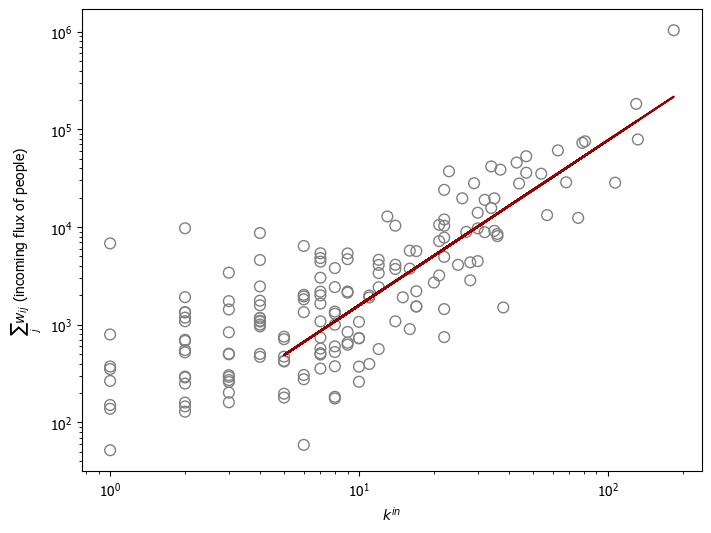

In [72]:
arr = [ elem for elem in node_tuple_in_conn_weight.values() if elem[0]>0 and elem[1]>0]
x, y = [ elem[0] for elem in node_tuple_in_conn_weight.values() ], [ elem[1] for elem in node_tuple_in_conn_weight.values() ] 

data_df = pd.DataFrame({'x': x, 'y': y})
data_df = data_df[data_df['x']>4]
print(data_df.shape)

logx = np.log10(data_df.x.values)
logy = np.log10(data_df.y.values)
xbase = data_df.x.values

slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
print(f"exponent: {slope}, prefactor: {intercept}, r_value: {r_value}, p_value: {p_value}, std_err: {std_err}")

predicted_logy = slope * logx + intercept
residuals = logy - predicted_logy
mse = np.mean(residuals ** 2)
print(f"MSE: {mse}")

fig, ax = plt.subplots(1, figsize=(8,6))

# data
ax.scatter(x, y, color='gray', facecolor='none', marker='o', s=60)

# fit
y_cidade = power_law_f(xbase, 10**intercept, slope)
ax.plot(xbase, y_cidade, ls="-", color="#990000", lw=1.5)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r"$k^{in}$")
ax.set_ylabel(r"$\sum_j w_{ij}$"+f" (incoming flux of people)")

In [15]:
out_degrees = dict(g.out_degree())
# -- convert the in-degrees to a DataFrame for better visualization
out_degrees_df = pd.DataFrame(list(out_degrees.items()), columns=['Municipality', 'Out-Degree'])

node_tuple_out_conn_weight = {}
for node in g.nodes:
    # -- get all incoming edges for the node
    out_edges = g.out_edges(node, data=True)
    if len(out_edges)==0:
        node_tuple_out_conn_weight.update({node: (0,0)})
    else:
        weight_sum = sum([ elem[2]['SOMA'] for elem in out_edges ])
        node_tuple_out_conn_weight.update({node: (len(out_edges), weight_sum)})

exponent: 2.729311876696968, prefactor: 0.5091589340292861, r_value: 0.798390542987682, p_value: 1.9899431881703048e-28, std_err: 0.18712962655002546
MSE: 0.06372238104405008


Text(0, 0.5, '$\\sum_i w_{ij}$ (outgoing flux of people)')

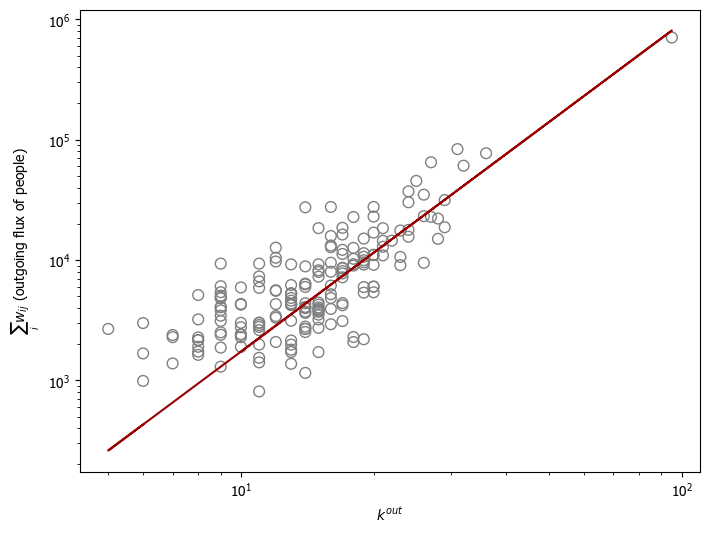

In [52]:
arr = [ elem for elem in node_tuple_out_conn_weight.values() if elem[0]>0 and elem[1]>0]
x, y = [ elem[0] for elem in node_tuple_out_conn_weight.values() ], [ elem[1] for elem in node_tuple_out_conn_weight.values() ] 

data_df = pd.DataFrame({'x': x, 'y': y})
data_df = data_df[data_df['x']>12]

logx = np.log10(data_df.x.values)
logy = np.log10(data_df.y.values)

slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
print(f"exponent: {slope}, prefactor: {intercept}, r_value: {r_value}, p_value: {p_value}, std_err: {std_err}")

predicted_logy = slope * logx + intercept
residuals = logy - predicted_logy
mse = np.mean(residuals ** 2)
print(f"MSE: {mse}")

fig, ax = plt.subplots(1, figsize=(8,6))

# data
ax.scatter(x, y, color='gray', facecolor='none', marker='o', s=60)

# fit 
y_cidade = power_law_f(x, 10**intercept, slope)
ax.plot(x, y_cidade, ls="-", color="#990000", lw=1.5)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r"$k^{out}$")
ax.set_ylabel(r"$\sum_i w_{ij}$"+f" (outgoing flux of people)")

In [53]:
data_df.shape

(123, 2)

### **City2Hospital Networks**

In [64]:
edgelist_df = pd.read_parquet(netpath.joinpath("c2h", f"c2h_diag_people_2014_2014.parquet"))
edgelist_df = edgelist_df.reset_index()
print(edgelist_df.shape)

# -- remove rows with municipalities out of Ceará
filter_ = edgelist_df["MUNIC_RES"].str.contains("^23", regex=True)
edgelist_df = edgelist_df[filter_]
print(edgelist_df.shape)

g = create_network(edgelist_df, net_type='c2h')
print(f'No. Nodes: {g.number_of_nodes()}, No. Edges: {g.number_of_edges()}')

(6380, 1322)
(5518, 1322)
No. Nodes: 419, No. Edges: 5518
